# Train

In [26]:
%run keras_retinanet/bin/train.py --batch-size 1 --epochs 1 --steps 5 0 csv dataset/deepfashion/instances_train2017.csv dataset/deepfashion/categories2017.csv

Creating generators, this may take a second...
Creating model, this may take a second...
features <class 'tuple'>
features 5
pyramid [<tf.Tensor 'regression_5/concat:0' shape=(?, ?, 4) dtype=float32>, <tf.Tensor 'classification_5/concat:0' shape=(?, ?, 51) dtype=float32>]
anchors (?, ?, 4)
[anchors] [<tf.Tensor 'concatenate_3/concat:0' shape=(?, ?, 4) dtype=float32>]
[anchors] + pyramid [<tf.Tensor 'concatenate_3/concat:0' shape=(?, ?, 4) dtype=float32>, <tf.Tensor 'regression_5/concat:0' shape=(?, ?, 4) dtype=float32>, <tf.Tensor 'classification_5/concat:0' shape=(?, ?, 51) dtype=float32>]


/Users/luke/Documents/github/fingerplus/edwin-jarvis/keras-retinanet/keras_retinanet/bin/train.py:89: UserWarning: Output "concatenate_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "concatenate_4" during training.
  optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)


Creating callback
dataset_type csv
training
Epoch 1/1
compute_input_output
inputs [[[[ 1.43061005e+02  1.34221008e+02  1.28320007e+02]
   [ 1.43058502e+02  1.34218506e+02  1.28317505e+02]
   [ 1.42723511e+02  1.33883514e+02  1.27982506e+02]
   ...
   [ 7.73599720e+00 -1.03999376e-01 -6.00500011e+00]
   [ 7.06599712e+00 -7.73999333e-01 -6.67500019e+00]
   [ 7.06099701e+00 -7.78999329e-01 -6.68000031e+00]]

  [[ 1.43061005e+02  1.34221008e+02  1.28320007e+02]
   [ 1.43058517e+02  1.34218521e+02  1.28317520e+02]
   [ 1.42724350e+02  1.33884354e+02  1.27983353e+02]
   ...
   [ 7.73349714e+00 -1.06499434e-01 -6.00750065e+00]
   [ 7.06349707e+00 -7.76499391e-01 -6.67750025e+00]
   [ 7.05849695e+00 -7.81499326e-01 -6.68250036e+00]]

  [[ 1.43061005e+02  1.34221008e+02  1.28320007e+02]
   [ 1.43059341e+02  1.34219345e+02  1.28318344e+02]
   [ 1.42837402e+02  1.33997406e+02  1.28096405e+02]
   ...
   [ 7.39849710e+00 -4.41499352e-01 -6.34250069e+00]
   [ 6.72849703e+00 -1.11149931e+00 -7.012500

inputs [[[[ 89.061      81.221      72.32     ]
   [ 89.061      81.221      72.32     ]
   [ 89.72766    81.887665   72.986664 ]
   ...
   [ 17.060997   -7.7790003   6.653332 ]
   [  5.060997  -20.779      -3.6800003]
   [  5.060997  -20.779      -3.6800003]]

  [[ 89.061      81.221      72.32     ]
   [ 89.061      81.221      72.32     ]
   [ 89.72766    81.887665   72.986664 ]
   ...
   [ 17.060997   -7.7790003   6.653332 ]
   [  5.060997  -20.779      -3.6800003]
   [  5.060997  -20.779      -3.6800003]]

  [[ 89.061      81.221      72.32     ]
   [ 89.061      81.221      72.32     ]
   [ 89.72766    81.887665   72.986664 ]
   ...
   [ 16.727663   -7.8901114   6.097777 ]
   [  5.060997  -20.445665   -4.013334 ]
   [  5.060997  -20.445665   -4.013334 ]]

  ...

  [[112.061      97.221      89.32     ]
   [112.061      97.221      89.32     ]
   [112.061      97.221      89.32     ]
   ...
   [117.061     102.221      94.32     ]
   [117.061     102.221      94.32     ]
   [117.0

inputs [[[[117.061   106.221    99.32   ]
   [117.061   106.221    99.32   ]
   [117.061   106.221    99.32   ]
   ...
   [121.061   108.221   101.32   ]
   [121.061   108.221   101.32   ]
   [121.061   108.221   101.32   ]]

  [[117.061   106.221    99.32   ]
   [117.061   106.221    99.32   ]
   [117.061   106.221    99.32   ]
   ...
   [121.061   108.221   101.32   ]
   [121.061   108.221   101.32   ]
   [121.061   108.221   101.32   ]]

  [[117.061   106.221    99.32   ]
   [117.061   106.221    99.32   ]
   [117.061   106.221    99.32   ]
   ...
   [121.061   108.221   101.32   ]
   [121.061   108.221   101.32   ]
   [121.061   108.221   101.32   ]]

  ...

  [[136.061   125.221   119.32   ]
   [136.061   125.221   119.32   ]
   [136.061   125.221   119.32   ]
   ...
   [143.061   132.22101 126.32   ]
   [143.061   132.22101 126.32   ]
   [143.061   132.22101 126.32   ]]

  [[136.061   125.221   119.32   ]
   [136.061   125.221   119.32   ]
   [136.061   125.221   119.32   ]
   ..

 3/50 [>.............................] - ETA: 16:29 - loss: 4.2474 - regression_loss: 1.4281 - classification_loss: 2.8193compute_input_output
inputs [[[[-76.939      -64.779      -91.68      ]
   [-76.776505   -64.6165     -91.5175    ]
   [-75.0015     -62.8415     -89.7425    ]
   ...
   [ -3.939003    22.221      -22.68      ]
   [ -3.939003    22.221      -22.68      ]
   [ -3.939003    22.221      -22.68      ]]

  [[-72.8765     -60.684      -87.455     ]
   [-72.71506    -60.522556   -87.29356   ]
   [-70.9516     -58.759094   -85.5301    ]
   ...
   [ -2.704003    23.391      -21.315     ]
   [ -2.704003    23.391      -21.315     ]
   [ -2.704003    23.391      -21.315     ]]

  [[-28.501505   -15.954      -41.305     ]
   [-28.351599   -15.804094   -41.155094  ]
   [-26.71416    -14.166657   -39.51766   ]
   ...
   [ 10.785996    36.171       -6.4050007 ]
   [ 10.785996    36.171       -6.4050007 ]
   [ 10.785996    36.171       -6.4050007 ]]

  ...

  [[-47.939003   -10.778

 7/50 [===>..........................] - ETA: 14:32 - loss: 3.8765 - regression_loss: 0.6121 - classification_loss: 3.2644compute_input_output
inputs [[[[144.061   138.22101 131.32   ]
   [144.1035  138.0935  131.10751]
   [144.46516 137.00851 129.29916]
   ...
   [149.44434 135.796   128.895  ]
   [150.891   137.966   131.065  ]
   [151.061   138.22101 131.32   ]]

  [[144.061   138.22101 131.32   ]
   [144.1035  138.0935  131.10751]
   [144.46516 137.00851 129.29916]
   ...
   [149.42717 135.77884 128.87782]
   [150.8892  137.9642  131.0632 ]
   [151.061   138.22101 131.32   ]]

  [[144.061   138.22101 131.32   ]
   [144.1035  138.0935  131.10751]
   [144.46516 137.00851 129.29916]
   ...
   [149.28099 135.63266 128.73166]
   [150.87383 137.94884 131.04784]
   [151.061   138.22101 131.32   ]]

  ...

  [[145.64351 134.80351 128.90251]
   [145.77101 134.93102 129.00525]
   [146.856   136.016   129.87958]
   ...
   [145.21011 134.84097 128.5929 ]
   [148.28247 137.49199 131.03323]
   [

11/50 [=====>........................] - ETA: 11:56 - loss: 3.7145 - regression_loss: 0.7452 - classification_loss: 2.9694compute_input_output
inputs [[[[ 53.060997  52.221     49.32    ]
   [ 55.755997  54.916     52.015   ]
   [ 62.21933   61.379333  58.478333]
   ...
   [ 34.473495  48.287666  50.349167]
   [ 49.708496  63.061     63.7375  ]
   [ 56.060997  69.221     69.32    ]]

  [[ 54.408497  53.5685    50.6675  ]
   [ 56.955273  56.115276  53.214275]
   [ 63.06312   62.223125  59.322124]
   ...
   [ 39.138412  52.952583  55.014084]
   [ 53.66245   67.01495   67.69145 ]
   [ 59.7185    72.8785    72.9775  ]]

  [[ 57.640163  56.800167  53.899166]
   [ 59.831455  58.99146   56.090458]
   [ 65.08676   64.246765  61.345764]
   ...
   [ 50.326134  64.140305  66.201805]
   [ 63.14508   76.49759   77.17409 ]
   [ 68.490166  81.65017   81.74917 ]]

  ...

  [[128.06934  129.80017  123.61167 ]
   [128.26184  129.99268  123.80417 ]
   [128.7235   130.45433  124.26584 ]
   ...
   [140.673

15/50 [========>.....................] - ETA: 10:27 - loss: 3.5862 - regression_loss: 0.5465 - classification_loss: 3.0397compute_input_output
inputs [[[[138.061   125.221   118.32   ]
   [138.061   125.221   118.32   ]
   [138.061   125.221   118.32   ]
   ...
   [143.061   130.22101 123.32   ]
   [143.061   130.22101 123.32   ]
   [143.061   130.22101 123.32   ]]

  [[138.061   125.221   118.32   ]
   [138.061   125.221   118.32   ]
   [138.061   125.221   118.32   ]
   ...
   [143.061   130.22101 123.32   ]
   [143.061   130.22101 123.32   ]
   [143.061   130.22101 123.32   ]]

  [[138.061   125.221   118.32   ]
   [138.061   125.221   118.32   ]
   [138.061   125.221   118.32   ]
   ...
   [143.061   130.22101 123.32   ]
   [143.061   130.22101 123.32   ]
   [143.061   130.22101 123.32   ]]

  ...

  [[115.061   102.221    95.32   ]
   [115.061   102.221    95.32   ]
   [115.061   102.221    95.32   ]
   ...
   [142.061   127.221   120.32   ]
   [142.061   127.221   120.32   ]
   [

19/50 [==========>...................] - ETA: 9:21 - loss: 3.7468 - regression_loss: 0.6707 - classification_loss: 3.0762compute_input_output
inputs [[[[151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   ...
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]]

  [[151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   ...
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]]

  [[151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   ...
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]]

  ...

  [[151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   ...
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [1

23/50 [============>.................] - ETA: 8:00 - loss: 3.7309 - regression_loss: 0.7351 - classification_loss: 2.9959compute_input_output
inputs [[[[151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   ...
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]]

  [[151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   ...
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]]

  [[151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   ...
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]]

  ...

  [[151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   ...
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [1

27/50 [===============>..............] - ETA: 6:49 - loss: 3.8629 - regression_loss: 0.9321 - classification_loss: 2.9308compute_input_output
inputs [[[[125.061 111.221 106.32 ]
   [125.061 111.221 106.32 ]
   [125.061 111.221 106.32 ]
   ...
   [122.061 108.221 103.32 ]
   [122.061 108.221 103.32 ]
   [122.061 108.221 103.32 ]]

  [[125.061 111.221 106.32 ]
   [125.061 111.221 106.32 ]
   [125.061 111.221 106.32 ]
   ...
   [122.061 108.221 103.32 ]
   [122.061 108.221 103.32 ]
   [122.061 108.221 103.32 ]]

  [[125.061 111.221 106.32 ]
   [125.061 111.221 106.32 ]
   [125.061 111.221 106.32 ]
   ...
   [122.061 108.221 103.32 ]
   [122.061 108.221 103.32 ]
   [122.061 108.221 103.32 ]]

  ...

  [[121.061 110.221 104.32 ]
   [121.061 110.221 104.32 ]
   [121.061 110.221 104.32 ]
   ...
   [124.061 110.221 105.32 ]
   [124.061 110.221 105.32 ]
   [124.061 110.221 105.32 ]]

  [[121.061 110.221 104.32 ]
   [121.061 110.221 104.32 ]
   [121.061 110.221 104.32 ]
   ...
   [124.061 110.22

31/50 [=================>............] - ETA: 5:30 - loss: 3.8790 - regression_loss: 1.0809 - classification_loss: 2.7981compute_input_output
inputs [[[[151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   ...
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]]

  [[151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   ...
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]]

  [[151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   ...
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]]

  ...

  [[151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   ...
   [151.061   138.22101 131.32   ]
   [151.061   138.22101 131.32   ]
   [1

35/50 [====================>.........] - ETA: 4:17 - loss: 3.7903 - regression_loss: 0.9574 - classification_loss: 2.8329compute_input_output
inputs [[[[122.061 109.221 102.32 ]
   [122.061 109.221 102.32 ]
   [122.061 109.221 102.32 ]
   ...
   [115.061 102.221  95.32 ]
   [115.061 102.221  95.32 ]
   [115.061 102.221  95.32 ]]

  [[122.061 109.221 102.32 ]
   [122.061 109.221 102.32 ]
   [122.061 109.221 102.32 ]
   ...
   [115.061 102.221  95.32 ]
   [115.061 102.221  95.32 ]
   [115.061 102.221  95.32 ]]

  [[122.061 109.221 102.32 ]
   [122.061 109.221 102.32 ]
   [122.061 109.221 102.32 ]
   ...
   [115.061 102.221  95.32 ]
   [115.061 102.221  95.32 ]
   [115.061 102.221  95.32 ]]

  ...

  [[122.061 111.221 104.32 ]
   [122.061 111.221 104.32 ]
   [122.061 111.221 104.32 ]
   ...
   [110.061  99.221  92.32 ]
   [110.061  99.221  92.32 ]
   [110.061  99.221  92.32 ]]

  [[122.061 111.221 104.32 ]
   [122.061 111.221 104.32 ]
   [122.061 111.221 104.32 ]
   ...
   [110.061  99.22

39/50 [======================>.......] - ETA: 3:04 - loss: 3.8061 - regression_loss: 1.0725 - classification_loss: 2.7336compute_input_output
inputs [[[[-72.939    -66.779    -58.68    ]
   [-72.886505 -66.7265   -58.6275  ]
   [-72.51817  -66.35817  -58.259167]
   ...
   [151.061    138.22101  131.32    ]
   [151.061    138.22101  131.32    ]
   [151.061    138.22101  131.32    ]]

  [[-72.939    -66.779    -58.68    ]
   [-72.886505 -66.7265   -58.6275  ]
   [-72.51817  -66.35817  -58.259167]
   ...
   [151.061    138.22101  131.32    ]
   [151.061    138.22101  131.32    ]
   [151.061    138.22101  131.32    ]]

  [[-72.939    -66.779    -58.68    ]
   [-72.886505 -66.7265   -58.6275  ]
   [-72.51817  -66.35817  -58.259167]
   ...
   [151.061    138.22101  131.32    ]
   [151.061    138.22101  131.32    ]
   [151.061    138.22101  131.32    ]]

  ...

  [[-60.359837 -43.199833 -33.100834]
   [-60.390244 -43.23024  -33.13124 ]
   [-60.60357  -43.443565 -33.344566]
   ...
   [150.061 

43/50 [========================>.....] - ETA: 1:56 - loss: 3.8324 - regression_loss: 1.1636 - classification_loss: 2.6688compute_input_output
inputs [[[[129.061    111.221    105.32    ]
   [129.061    111.221    105.32    ]
   [129.061    111.221    105.32    ]
   ...
   [110.061     97.221     90.32    ]
   [110.061     97.221     90.32    ]
   [110.061     97.221     90.32    ]]

  [[129.061    111.221    105.32    ]
   [129.061    111.221    105.32    ]
   [129.061    111.221    105.32    ]
   ...
   [110.061     97.221     90.32    ]
   [110.061     97.221     90.32    ]
   [110.061     97.221     90.32    ]]

  [[129.061    111.221    105.32    ]
   [129.061    111.221    105.32    ]
   [129.061    111.221    105.32    ]
   ...
   [110.061     97.221     90.32    ]
   [110.061     97.221     90.32    ]
   [110.061     97.221     90.32    ]]

  ...

  [[112.061     99.221     92.32    ]
   [112.061     99.221     92.32    ]
   [112.061     99.221     92.32    ]
   ...
   [ 94.4151

47/50 [===========================>..] - ETA: 49s - loss: 3.8300 - regression_loss: 1.1500 - classification_loss: 2.6800 compute_input_output
inputs [[[[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  ...

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

/Users/luke/.pyenv/versions/3.6.3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/luke/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [8]:
model = keras.models.load_model('snapshots/resnet50_csv_02.h5', custom_objects=custom_objects)

SystemError: unknown opcode

In [4]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
val_generator = CSVGenerator(
    "dataset/deepfashion/instances_val2017.csv",
    "dataset/deepfashion/categories2017.csv",
    batch_size=1,
)
index = 0

processing time:  7.025563716888428


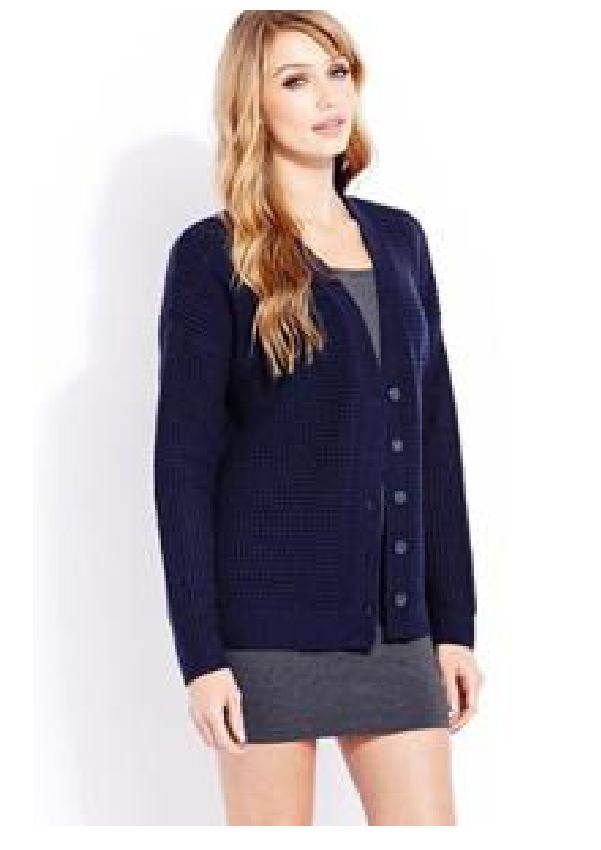

In [5]:
# load image
image = val_generator.load_image(index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = val_generator.preprocess_image(image)
image, scale = val_generator.resize_image(image)
annotations = val_generator.load_annotations(index)
index += 1

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels] 

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
    print(val_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize annotations
# for annotation in annotations:
#     label = int(annotation[4])
#     b = annotation[:4].astype(int)
#     cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
#     caption = "{}".format(val_generator.label_to_name(label))
#     cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
#     cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()